Given target altitude of: 3048 and a deployment level of 0.0% at angle of 90
the rocket will need to begin deployment at 2272.8m at speed 275.14224145879984



FileNotFoundError: [Errno 2] No such file or directory: 'BackwardsAirbrakeSimulation\\SourceFiles\\Angle0Level0%.csv'

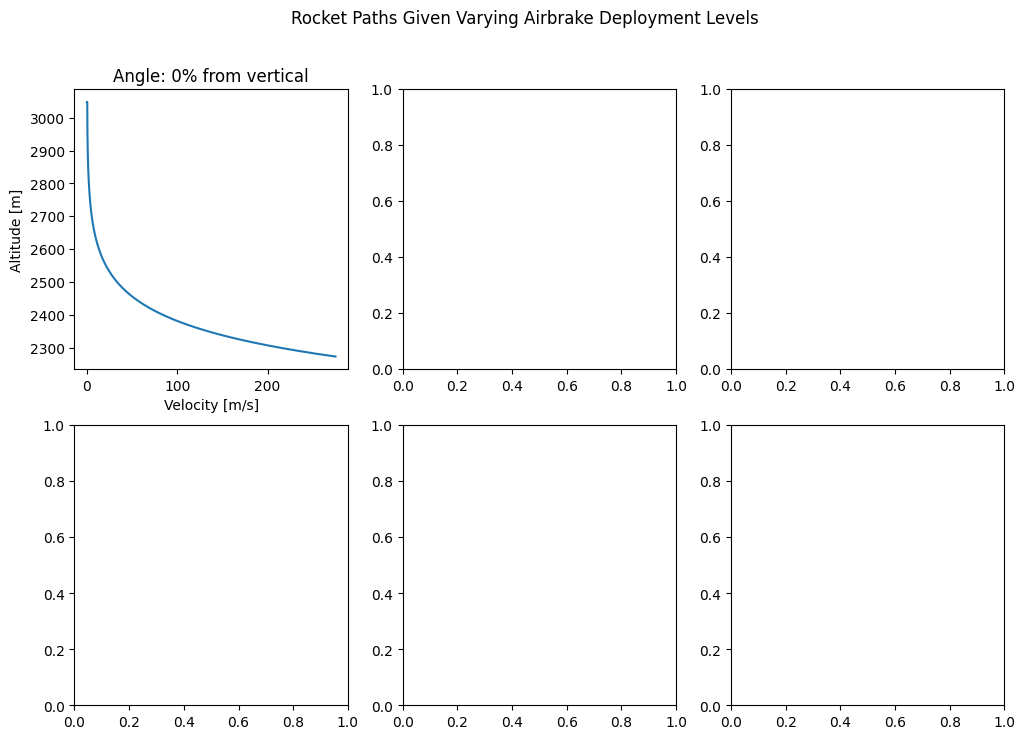

In [1]:
#Backwards Simulation
#from pyatmos import expo
import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
import csv
import math as Math
from concurrent.futures import ProcessPoolExecutor, as_completed
import time
import pandas as pd
#2-Dimensional Physics
def BestDeployLevel(angle, altitude, velocity, maxAlt, step):
    differences = []
    for level in range (11):
        alt = []
        vel = []
        with open(f"BackwardsAirbrakeSimulation\SourceFiles/Angle{angle}Level{level*10}%.csv", 'r') as sourceFile:
            reader = csv.reader(sourceFile)
            currentRow = next(reader)
            minAlt = float(currentRow[0])
            done = False
            while done == False and float(currentRow[0]) <= 3048:
                alt.append(float(currentRow[0]))
                vel.append(float(currentRow[1]))
                currentRow = next(reader)
                while done == False and currentRow == []:
                    try:
                        currentRow = next(reader)
                    except Exception as e:
                        done = True
                        print(e)
        numIndex = (maxAlt-minAlt)/step
        i = 0
        j = round(numIndex, 1)
        k = int((j-i)/2)
        if altitude < alt[i]:
            j = -1
        while i <= j and alt[k] != altitude:
            #print(f"{alt[k]} {altitude}")
            if alt[k] < altitude:
                i = k + 1
            else:
                j = k - 1
            k = i + int((j-i)/2)
            #print (f"{alt[i]} {alt[k]} {alt[j]} {altitude}")
        if i > j:
            differences.append(1000)
        else:
            differences.append(abs(vel[k] - velocity))
    print(differences)
    
    closest = min(differences)
    index = differences.index(closest)
    print(f"Best deployment level at altitude: {altitude} and velocity: {velocity} is {index*10}%")
    return index*10

targetAltitude = 3048 #Target altitude in m
step = .1
maxSpeed = 275 #Deployment limiter of airbrakes based on rocket speed
angle = 90 #Launch angle in degrees from x-axis
R = 287.05 #Specific gas constant
Ru = 8.314 #Universal gas constant
T0 = 300 #Temp at sea level
P0 = 101325 #Air pressure at sea level
M = 0.0289644 #Molar mass of air
L = .0098 #Lapse rateg = 9.81 #Acceleration of gravity
g = 9.81 #Acceleration of gravity
m = 27.5 #Rocket's mass in kg
CdABody = .5376 #Drag*Area of rocket body
x = 0 #Horizontal position of the rocket
y = targetAltitude #Vertical position of the rocket
p0 = [x, y] #Tuple representing positional vector of the rocket
initialSpeed = .5 #Speed of rocket at target apogee in m/s (non-zero due to calculation issues)
v0 = [initialSpeed*Math.cos(Math.radians(angle)), initialSpeed*Math.sin(Math.radians(angle))] #Velocity vector of the rocket at apogee

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
lines = []
plt.suptitle(f"Rocket Paths Given Varying Airbrake Deployment Levels")

for i in range (6):
    angle = 90 - i*5
    # add multiprocessing here <--
    for j in range (11):
        altitude = targetAltitude #Changing altitude
        velocity = [initialSpeed*Math.cos(Math.radians(angle)), initialSpeed*Math.sin(Math.radians(angle))] #Set initial velocity
        speed = initialSpeed
        position = p0
        brakeLevel = j/10.0 #Brake level as decimal for computing
        CdABrakes = CdABody*.5*brakeLevel #Drag*Area of airbrakes
        CdATotal = CdABody + CdABrakes #Total drag of the rocket
        counter = 0 #Keeps track of the number of steps
        angles = []
        velocities = [] #Holds the velocity information at each step for plotting
        altitudes = [] #Holds the altitude information at each step for plotting
        velocities.append(0) #initial starting conditions
        angles.append(65)
        altitudes.append(3048)
        print(f"Given target altitude of: {targetAltitude} and a deployment level of {brakeLevel*100}% at angle of {angle}")

        while speed <= maxSpeed:
            T = T0-(L*altitude)
            P = P0*Math.exp(-1*M*g*altitude/(Ru*T))
            rho = P/(R*T)
            dvxdh = abs(-(-(.5*(1.0/m))*(rho)*speed*speed*CdATotal)/speed*Math.sin(Math.radians(angle))) #Change in velocity over altitude
            dvydh = abs(-(-1*g-(.5*(1.0/m))*(rho)*speed*speed*CdATotal)/speed*Math.cos(Math.radians(angle))) #Change in velocity over altitude
            velocity[0] = velocity[0] + dvxdh*step
            velocity[1] = velocity[1] + dvydh*step
            speed = Math.sqrt(Math.pow(velocity[0], 2) + Math.pow(velocity[1], 2))
            altitude = round(altitude - step, 1)
            counter += 1
            velocities.insert(0, speed) #Holds data for plotting 
            angles.insert(0, angle)
            altitudes.insert(0, altitude)
            #print(f"The change in velocity is: {dvydh*step}, the new velocity is {speed}m")

        k = int(i/3)
        l = i%3
        (line,) = ax[k, l].plot(velocities, altitudes, label=f"{int(brakeLevel*100)}%")
        lines.append(line)
        print(f"the rocket will need to begin deployment at {altitude}m at speed {speed}\n")

        """leg = ax[k, l].legend(loc="upper right")
        for legline, origline in zip(leg.get_lines(), lines):
            legline.set_picker(True)  # make legend entries clickable

        def on_pick(event):
            legline = event.artist
            index = leg.get_lines().index(legline)
            origline = lines[index]
            visible = not origline.get_visible()
            origline.set_visible(visible)
            legline.set_alpha(1.0 if visible else 0.2)  # dim legend if hidden
            fig.canvas.draw()

        fig.canvas.mpl_connect("pick_event", on_pick)"""

        ax[k,l].set_title(f"Angle: {90 - angle}% from vertical")
        ax[k,l].set_xlabel("Velocity [m/s]")
        ax[k,l].set_ylabel("Altitude [m]")

        with open(f"BackwardsAirbrakeSimulation\SourceFiles\Angle{90 - angle}Level{j*10}%.csv", 'w') as file:
            writer = csv.writer(file)
            for v, a in zip(altitudes, velocities):
                writer.writerow([v, a])

# START FROM HERE
        
fig.tight_layout(h_pad=3, w_pad=5)
plt.savefig('BackwardsAirbrakeSimulation\SimResults.png')
#plt.show()

startTime = time.time()
numVel = 10
numAlt = 10
numAng = 6
progressCounter = 0
minVelocity = .5
maxVelocity = 275
velStep = (maxVelocity-minVelocity)/(numAng-1)
maxAltitude = 3048

def getCSVForAngle(ang):
    with open(f"BackwardsAirbrakeSimulation/Angle{ang}.csv", 'w') as ResultFile:
        writer = csv.writer(ResultFile)
        minAltitude = 0
        with open(f"BackwardsAirbrakeSimulation/SourceFiles/Angle{ang*5}Level0%.csv",'r') as file:
            reader = csv.reader(file)
            minAltitude = float(next(reader)[0])
        altStep = (maxAltitude-minAltitude)/(numAlt-1)
        for vel in range (numVel):
            currentVelocity = minVelocity + velStep*vel
            row = []
            for alt in range (numAlt):
                currentAltitude = round(maxAltitude - altStep*alt, 1)
                if (currentAltitude == 3048):
                    deployLevel = 100
                elif (currentAltitude >= minAltitude):
                    deployLevel = BestDeployLevel(ang*5, currentAltitude, currentVelocity, maxAltitude, step)
                else:
                    deployLevel = 0
                # progressCounter += 1

                '''
                load progressCounter into variable v
                add v by 1
                save back in v to progresscounter'''

                row.append(deployLevel)
            writer.writerow(row)
            # with open("BackwardsAirbrakeSimulation\progress.txt", 'w') as progress:
            #     progressPercentage = progressCounter*100/(numVel*numAng*numAlt)
            #     currentTime = time.time()
            #     currentRuntime = (currentTime - startTime)
            #     estimatedRuntime = 100*currentRuntime/progressPercentage
            #     progress.write(f"Current Progress: {progressPercentage:.4f}%")
            #     progress.write(f"\nCurrent Runtime: {currentRuntime:.4f}\nEstimated Runtime: {estimatedRuntime:.4f}")
    return ang

if __name__ == "__main__":
    with ProcessPoolExecutor(max_workers = numAng) as executor:
        results = []
        for i in range(0, numAng, 1):
            processCall = executor.submit(getCSVForAngle, i)
            results.append(processCall)
        for result in as_completed(results):
            returnedValue = result.result()
            print(f"Angle {returnedValue}, csv file should be done")

endTime = time.time()
execution_time = endTime - startTime
print(f"Runtime: {execution_time:.4f}")

finalDf = pd.DataFrame()

with open("BackwardsAirbrakeSimulation/LookupTable.csv", "w") as tableFile:
    for i in range(numAng):
        angleDf = pd.read_csv(f"BackwardsAirbrakeSimulation/Angle{i}.csv")
        finalDf = pd.concat([finalDf, angleDf], ignore_index=True)

finalDf.to_csv("LookupTable.csv")
        
'''
# 1-Dimensional Physics
targetAltitude = 3048 #Target altitude in m
step = .1 #Step size in m
maxSpeed = 275 #Deployment limiter of airbrakes based on rocket speed
R = 287.05 #Specific gas constant
Ru = 8.314 #Universal gas constant
T0 = 300 #Temp at sea level
P0 = 101325 #Air pressure at sea level
M = 0.0289644 #Molar mass of air
L = .0098 #Lapse rate
g = 9.81 #Acceleration of gravity
m = 27.5 #Rocket's mass in kg
v0 = .5 #Initial velocity of rocket in m/s
brakeLevel = 1 #Percentage of airbrake deployment
CdABody = .5376 #Drag*Area of rocket body

fig, ax = plt.subplots(figsize=(8, 6))
lines = []

for i in range (11):
    altitude = targetAltitude #Changing altitude
    v = v0 #Changing velocity
    brakeLevel = i/10.0 #Brake level as decimal for computing
    CdABrakes = CdABody*.35*brakeLevel #Drag*Area of airbrakes
    CdATotal = CdABody + CdABrakes #Total drag of the rocket
    counter = 0 #Keeps track of the number of steps
    velocities = [] #Holds the velocity information at each step for plotting
    altitudes = [] #Holds the altitude information at each step for plotting
    velocities.append(0) #initial starting conditions
    altitudes.append(3048)
    print(f"Given target altitude of: {targetAltitude} and a deployment level of {brakeLevel*100}%")

    while v <= maxSpeed:
        #expo_geom = expo([altitude/1000]) # Access air density at altitude (km)
        T = T0-(L*altitude)
        P = P0*Math.exp(-1*M*g*altitude/(Ru*T))
        rho = P/(R*T)
        dvdh = -(-1*g-(.5*(1.0/m))*(rho)*v*v*CdATotal)/v #Change in velocity over altitude
        altitude = altitude-step #Linear approximation for altitude
        v = v+dvdh*step #Linear approximation for velocity
        counter += 1
        velocities.append(v) #Holds data for plotting 
        altitudes.append(altitude)
        #print(f"The change in velocity is: {dvdh*step}, the new velocity is {v}m")

    (line,) = ax.plot(velocities, altitudes, label=f"{int(brakeLevel*100)}%")
    lines.append(line)
    print(f"the rocket will need to begin deployment at {altitude}m\n")

leg = ax.legend(loc="upper right")
for legline, origline in zip(leg.get_lines(), lines):
    legline.set_picker(True)  # make legend entries clickable

def on_pick(event):
    legline = event.artist
    index = leg.get_lines().index(legline)
    origline = lines[index]
    visible = not origline.get_visible()
    origline.set_visible(visible)
    legline.set_alpha(1.0 if visible else 0.2)  # dim legend if hidden
    fig.canvas.draw()

fig.canvas.mpl_connect("pick_event", on_pick)


plt.title("Rocket Paths Given Varying Airbrake Deployment Levels")
plt.xlabel("Velocity [m/s]")
plt.ylabel("Altitude [m]")
plt.show()
'''